# Introduction

This analysis seeks to add understanding to data regarding police interactions known as Terry stops. According to [Merriam-Webster](https://www.merriam-webster.com/legal/Terry%20stop), a Terry stop is "a stop and limited search of a person for weapons justified by a police officer's reasonable conclusion that a crime is being or about to be committed by a person who may be armed and whose responses to questioning do not dispel the officer's fear of danger to the officer or to others." This type of interaction will be analyzed in depth.

More specifically, the analysis will create a model to predict whether an infraction will be added to a subject's record -- whether that is through an arrest, referral for prosecution, citation or offense report. A criminal record can have enormous impacts on an individual's life, and whether or not a subject gets let off or not have countless consequences, including employment, child custody, adoption, driving, firearms, immigration, punishment for subsequent crimes, financial aid for college admissions, and housing, among others [(1)](https://www.nealdavislaw.com/criminal-defense-guides/criminal-record-consequences.html). As a result of these lasting consequences, it can be valuable to understand patterns and potential biases within the way infractions are addressed within different demographics. The analysis explores topics such as race, gender, age, location, and more. 


## Data Sources

The city of Seattle [provides](https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8) substantial publicly available data about these encounters. There are over 47,000 records spanning a period from 2015 to 2021. It includes 23 different features, including topics such as race, gender, age, location, call type, and the final resolution of the stop -- whether it ended in arrest or citation, for example.

## The Process
This analysis will follow the general structure listed here:
1. Setup and Data Import
2. Data Cleaning
3. Feature Engineering
4. Graphical Exploratory Data Analysis (EDA)
5. Feature Selection
6. Modeling
7. Results Interpretation
8. Conclusion

### Additional Notes
This notebook provides a somewhat condensed analysis compared to the full sequence necessary to understand the all details of choosing specific models and the nitty-gritty details of feature selection. Please refer to the EDA notebook in this folder for that analysis.

## Part I: Setup and Data Import
**Import relevant packages**

In [1]:
# Basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os, sys
from datetime import time

# Data manipulation packages
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Modeling packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import KFold, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from xgboost import XGBClassifier

# Model evaluation packages
import shap
from sklearn.metrics import f1_score, plot_confusion_matrix

# Basic settings for an easier to use notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline
pd.set_option('display.max_columns', 100)


path_to_src = os.path.join('..', 'src')
sys.path.insert(1, path_to_src)
from custom_functions import *

**Declare static variables used throughout notebook**

In [2]:
# Global static variable declarations used throughout notebook
RANDOM_STATE = 0
raw_terry_path = os.path.join('..', 'data', 'raw', 'terry-stops.csv')
processed_data_path = os.path.join('..', 'data', 'processed')
path_to_figures = os.path.join('..', 'images')



UNKNOWN = 'Not provided'
N_SPLITS = 3
JOBS = 2

**Import full dataset from *data* folder**

In [3]:
df = pd.read_csv(raw_terry_path, dtype='str')

# Strip spaces, as relevant
for col in df.columns:
    df[col] = df[col].str.strip()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47213 entries, 0 to 47212
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         47213 non-null  object
 1   Subject ID                47213 non-null  object
 2   GO / SC Num               47213 non-null  object
 3   Terry Stop ID             47213 non-null  object
 4   Stop Resolution           47213 non-null  object
 5   Weapon Type               47213 non-null  object
 6   Officer ID                47213 non-null  object
 7   Officer YOB               47213 non-null  object
 8   Officer Gender            47213 non-null  object
 9   Officer Race              47213 non-null  object
 10  Subject Perceived Race    47213 non-null  object
 11  Subject Perceived Gender  47213 non-null  object
 12  Reported Date             47213 non-null  object
 13  Reported Time             47213 non-null  object
 14  Initial Call Type     

# Part II: Data Cleaning
**Dictionaries are used to categorize, reclassify, and correct typographical errors for each column as relevant.**

In [5]:
# ------ CLEAN DATA ONE COLUMN AT A TIME -------

# Subject Age Group
df['Subject Age Group'].replace('-', np.nan, inplace=True)

# Subject ID
df['Subject ID'].replace('-1', UNKNOWN, inplace=True)


# Officer Year of Birth
df['Officer YOB'] = df['Officer YOB'].astype('int')


# Officer Race
race_dict = {'Unknown': UNKNOWN, 
            'Not Specified': UNKNOWN,
            '-': UNKNOWN,
            'Other': UNKNOWN, 
            'Unknown': UNKNOWN}
df['Officer Race'].replace(race_dict, inplace=True)
df['Subject Perceived Race'].replace(race_dict, inplace=True)


# Gender
gender_dict = {'Unable to Determine': UNKNOWN,
              '-': UNKNOWN,
               'Unknown': UNKNOWN,
              'Gender Diverse (gender non-conforming and/or transgender)': 'Non-Binary',
               'N': 'Non-Binary',
               'M': 'Male',
               'F': 'Female'}
df['Subject Perceived Gender'].replace(gender_dict, inplace=True)
df['Officer Gender'].replace(gender_dict, inplace=True)


# Race - grouped for naming consistency and aggregating small sample sizes 
# for statistical significance
race_dict = {'Two or More Races': 'Multi-Racial',
            'Hispanic or Latino': 'Hispanic',
            'Nat Hawaiian/Oth Pac Islander': 'Native', 
            'American Indian/Alaska Native': 'Native',
            'Native Hawaiian or Other Pacific Islander': 'Native',
            'American Indian or Alaska Native': 'Native'}
df['Subject Perceived Race'].replace(race_dict, inplace=True)
df['Officer Race'].replace(race_dict, inplace=True)


# Reported date and hour
df['Reported Date'] = df['Reported Date'].astype('datetime64')
    
    
# Call Type
call_type_dict = {'-': UNKNOWN,
                 'SCHEDULED EVENT (RECURRING)': UNKNOWN,
                 'TEXT MESSAGE': UNKNOWN,
                 'TELEPHONE OTHER, NOT 911': UNKNOWN,
                 'ONVIEW': 'Onview', 
                 'ALARM CALL (NOT POLICE ALARM)': 'Alarm'}
df['Call Type'].replace(call_type_dict, inplace=True)
    
    
# Frisk Flag
df['Frisk Flag'].replace('-', np.nan, inplace=True)


# Precinct
precinct_dict = {'-': UNKNOWN,
                'FK ERROR': UNKNOWN,
                 'Unknown': UNKNOWN,
                'SouthWest': 'Southwest', 
                'OOJ': UNKNOWN}
df['Precinct'].replace(precinct_dict, inplace=True)


# Sector
df['Sector'].replace(['99', '-'], UNKNOWN, inplace=True)


# Subject age group
df['Subject Age Group'].replace('-', np.nan, inplace=True)


# Required for downstream one-hot encoding
df['Officer Squad'].fillna(UNKNOWN, inplace=True)


# Change 'Y' and 'N' to binary 1/0
df['Arrest (Y/N)'] = (df['Arrest Flag'] == 'Y').astype('int')
df.drop('Arrest Flag', axis=1, inplace=True)
    
# Change 'Y' and 'N' to binary 1/0
df['Frisk (Y/N)'] = (df['Frisk Flag'] == 'Y').astype('int')
df.drop('Frisk Flag', axis=1, inplace=True)


# Difficult decision to make, but with a sample size of only 5 people, the 
# amount of data is insufficient to provide a statistically significant 
# understanding of how non-binary appearance affects arrest rate
df['Subject Perceived Gender'].replace('Non-Binary', UNKNOWN, inplace=True)
df['Officer Gender'].replace('Non-Binary', UNKNOWN, inplace=True)


# Weapon Type
weapon_type_dict = {'Firearm Other': 'Firearm', 
                    'Lethal Cutting Instrument': 'Knife', 
                    'Handgun': 'Firearm', 
                    '-': 'None', 
                    'Club, Blackjack, Brass Knuckles': UNKNOWN, 
                    'Knife/Cutting/Stabbing Instrument': 'Knife', 
                    'Other Firearm': 'Firearm', 
                    'Rifle': 'Firearm', 
                    'Fire/Incendiary Device': UNKNOWN, 
                    'Blunt Object/Striking Implement': UNKNOWN, 
                    'Firearm (unk type)': 'Firearm', 
                    'Mace/Pepper Spray': UNKNOWN, 
                    'None/Not Applicable': 'None', 
                    'Club': UNKNOWN, 
                    'Taser/Stun Gun': UNKNOWN, 
                    'Shotgun': 'Firearm', 
                    'Brass Knuckles': UNKNOWN, 
                    'Automatic Handgun': 'Firearm', 
                    'Blackjack': UNKNOWN, 
                    'Personal Weapons (hands, feet, etc.)': UNKNOWN}
df['Weapon Type'].replace(weapon_type_dict, inplace=True)



# Remove missing values
df.dropna(inplace=True)

**Display info about the remaining data**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45664 entries, 214 to 47212
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Subject Age Group         45664 non-null  object        
 1   Subject ID                45664 non-null  object        
 2   GO / SC Num               45664 non-null  object        
 3   Terry Stop ID             45664 non-null  object        
 4   Stop Resolution           45664 non-null  object        
 5   Weapon Type               45664 non-null  object        
 6   Officer ID                45664 non-null  object        
 7   Officer YOB               45664 non-null  int32         
 8   Officer Gender            45664 non-null  object        
 9   Officer Race              45664 non-null  object        
 10  Subject Perceived Race    45664 non-null  object        
 11  Subject Perceived Gender  45664 non-null  object        
 12  Reported Date   

# Part III: Feature Engineering
**See EDA notebook for more details on feature engineering. Below are the final selected choices.**

**Calculate officer age based on their year of birth and the year the Terry stop occurred.**

In [7]:
df['Officer Age'] = df['Reported Date'].apply(lambda x: x.year) - \
                    df['Officer YOB']

# Fill missing values with median
# Note there are some outliers with unrealistically high ages. Replace w/median
median_age = df.loc[df['Officer Age']<100, 'Officer Age'].median()
replace_with_med = lambda x: median_age if x > 100 else x
df['Officer Age'] = df['Officer Age'].apply(replace_with_med).astype('int')
df.drop('Officer YOB', axis=1, inplace=True)

**Create binary metric indicating whether the subject had a weapon.**

In [8]:
df['Weapon (Y/N)'] = (df['Weapon Type'] != 'None').astype('int')

**Identify whether the officer is of the same race and same gender as the subject.**

In [9]:
#Race
df['Same Race (Y/N)'] = (df['Officer Race'] == df['Subject Perceived Race'])\
                                               .astype('int')

# Gender
df['Same Gender (Y/N)'] = (df['Officer Gender'] == \
                           df['Subject Perceived Gender']).astype('int')

**Estimate subject age based on the categorical age buckets and the statistical distribution of ages within the dataset.** 

Note that these estimates are never outside of the age "buckets" provided in the original dataset so no data integrity is lost. Instead, granularity is added that does, in aggregate, bring increased accuracy to the feature. The red dots represent a histogram of each age bucket in the original dataset. For example, there are roughly 600 records categorized in the 45-55 years old bucket. The blue lines represent a histogram of the estimated ages in the final dataset. They are sampled from a distribution of the overall age buckets. In the EDA section, it was determined that this methodology provides a small degree of increased model accuracy over the alternative of age bracket categories. 

Avg: 34.47090666023801, std: 17.752934029806642


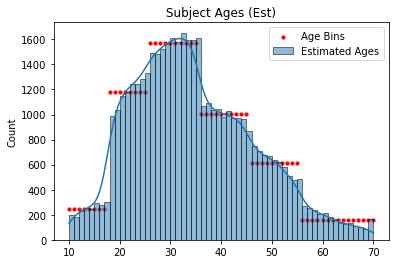

In [60]:
from estimate_ages import estimate_age_from_categorical
df['Subject Age (Est)'] = estimate_age_from_categorical(df)

# Remove the categorical feature after estimating the continuous feature 
# based on its values
#df.drop('Subject Age Group', axis=1, inplace=True)

In [ ]:
stop

**Categorize "Stop Resolution" to create an appropriate target metric.**

The most appropriate target was determined to be one that will have a lasting impact on the subject's criminal record. Refer to the below dictionary to see how those are classified. 

**Going forward, a "negative outcome" refers to a resolution that will persist on the subject's criminal record following the interaction.**

In [ ]:
dict_resolution = {
    'Field Contact': 'Neutral',
    'Offense Report': 'Negative',
    'Arrest': 'Negative',
    'Referred for Prosecution': 'Negative',
    'Citation / Infraction': 'Negative'}

df['Resolution: Negative (Y/N)'] = (df['Stop Resolution'].map(dict_resolution)\
                                    == 'Negative')
df['Resolution: Negative (Y/N)'] = (df['Resolution: Negative (Y/N)'])\
                                   .astype('int')

# Remove original pre-categorization feature
df.drop('Stop Resolution', axis=1, inplace=True)

In [ ]:
# Remove missing values and reset index
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

# Part IV: Graphical EDA

Explore the relationships between selected features.

**First, investigate the relationship between age and a negative outcome.**

In [ ]:
# Create data to plot
min_age = df['Subject Age (Est)'].min()
max_age = df['Subject Age (Est)'].max()
ages = list(range(min_age, max_age+1))
negative_outcome_ct = []
negative_outcome_rate = []

for age in ages:
    grouped = df.loc[df['Subject Age (Est)'] == age]
    target = grouped['Resolution: Negative (Y/N)']
    negative_outcome_ct.append(target.sum())
    negative_outcome_rate.append(target.mean())

    
# Create plot
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14, 6))
plt.suptitle('Relationship Between Subject Age and Negative Outcome', 
             fontsize=18)

axes[0].plot(ages, negative_outcome_rate)
axes[0].set_ylabel('Average Rate of Negative Outcome (%)', fontsize=15)
axes[0].set_xlabel('Age', fontsize=15)
axes[0].tick_params('x', labelsize=15)


axes[1].bar(ages, negative_outcome_ct)
axes[1].set_ylabel('Total Negative Outcomes in Dataset', fontsize=15);


axes[1].set_xlabel('Age', fontsize=15)
axes[1].tick_params('x', labelsize=15)

name = 'Subject-Age-vs.-Negative-Outcome.png'
path = os.path.join(path_to_figures, name)
fig.savefig(path)

**Investigate the relationship between Officer Age and a negative outcome**

In [ ]:
# Create data to plot
min_age = df['Officer Age'].min()
max_age = df['Officer Age'].max()
ages = list(range(min_age, max_age+1))
negative_outcome_ct = []
negative_outcome_rate = []

for age in ages:
    grouped = df.loc[df['Officer Age'] == age]
    target = grouped['Resolution: Negative (Y/N)']
    negative_outcome_ct.append(target.sum())
    negative_outcome_rate.append(target.mean())

    
# Create plot
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14, 6))
plt.suptitle('Relationship Between Officer Age and Negative Outcome')

axes[0].plot(ages, negative_outcome_rate)
axes[0].set_ylabel('Average Rate of Negative Outcome (%)')

axes[1].bar(ages, negative_outcome_ct)
axes[1].set_ylabel('Total Negative Outcomes in Dataset');

name = 'Officer-Age-vs.-Negative-Outcome.png'
path = os.path.join(path_to_figures, name)
fig.savefig(path)

**Investigate the relationship between subject race and a negative outcome**

In [ ]:
# Create data to plot
subject_races = df['Subject Perceived Race'].unique()
negative_outcome_ct = []
negative_outcome_rate = []

for race in subject_races:
    grouped = df.loc[df['Subject Perceived Race'] == race]
    target = grouped['Resolution: Negative (Y/N)']
    negative_outcome_ct.append(target.sum())
    negative_outcome_rate.append(target.mean())

# Sort results in descending order
zipped = zip(subject_races, negative_outcome_rate)
zipped_sorted = sorted(zipped, key = lambda x: x[1], reverse=False)

# Extract from tuples
races = [x[0] for x in zipped_sorted]
rates = [x[1] for x in zipped_sorted]


# Create plot - AVERAGE RATE OF NEGATIVE OUTCOME
plt.tight_layout()
plt.figure(figsize=(8, 4))
plt.title('Relationship Between Subject Race and Negative Outcome', 
          fontsize=20)
plt.barh(races, rates)
plt.xlabel('Average Rate of Negative Outcome (%)');
plt.xlim(0,0.8)


for index,data in enumerate(rates):
    plt.text(y=index , x =data + 0.01 , s=f"{round(data, 3)}")
    
plt.tight_layout()
name = 'Subject-Race-vs.-Arrest-Rate.png'
path = os.path.join(path_to_figures, name)
plt.savefig(path)

**Investigate other interesting relationships**

In [ ]:
# Gender metrics
x_axis = 'Subject Perceived Gender'
y_axis = ['Resolution: Negative (Y/N)']
bar_plot(df, x_axis, y_axis, 'mean', verbose=True)

# Officer race
x_axis = 'Officer Race'
bar_plot(df, x_axis, y_axis, 'mean',verbose=True)

# Officer gender
x_axis = 'Officer Gender'
bar_plot(df, x_axis, y_axis, 'mean', verbose=True)

# Part V: Feature Selection
Most of the feature selection has already been completed through the feature cleaning and engineering processes. However, it is now time to select only the most appropriate features. Below, two types of features are selected: 1) those with continuous values, and 2) those with a categorical nature. Categoricals are identified as those with a reasonable small number of features. For example, although Officer ID is a non-continuous feature, there are over 1,200 officers in the database, which would create an unreasonable dataset once one-hot encoded as an input to the models. 

In [ ]:
# Separate columns by type
obj_columns = df.select_dtypes('object').columns
continuous_columns = df.select_dtypes('number').columns

# Determine which columns are most valuable to OHE based on small 
# enough number of values
cols_to_ohe = []
for col in obj_columns:
    if len(df[col].value_counts().index) < 30:
        cols_to_ohe.append(col)
    else:
        print('Excluding:', col)

# Create new dataframe with only selected features
df_refined = pd.concat([df[continuous_columns], df[cols_to_ohe]], axis=1)

# Print features that are to be included in modeling process
print('----------')
[print('Including:', x) for x in df_refined.columns];

**Plot distributions for features that are to be included.**

In [ ]:
# Determine number of subplots necessary based on number of features included
nrows = int(np.ceil(df_refined.shape[1]/4))
fig, axes = plt.subplots(ncols=4, nrows=nrows, figsize=(22, 4*nrows))

# Plot each feature on its respective axis
for ax, col in zip(axes.flatten(), df_refined.columns):
    ax.hist(df_refined[col])
    ax.set_title(col, fontdict={'fontsize': 22})
    
    if (len(df_refined[col].unique()) > 3) and \
       (len(df_refined[col].unique()) < 40):
        rotation=90
    else:
        rotation=0
    ax.tick_params('x', labelrotation=rotation, labelsize=16)
    
plt.subplots_adjust(wspace=.7, hspace=1)
plt.suptitle('Select Feature Distributions', fontsize=25)

name = 'Data-Distributions.png'
path = os.path.join(path_to_figures, name)
fig.savefig(path)

# Part VI: Modeling

Start by isolating test and train datasets

In [ ]:
# Create X and y to hold inputs and target, respectively
df_refined.reset_index(inplace=True, drop=True)
y_label = 'Resolution: Negative (Y/N)'
X = df_refined.drop([y_label,'Frisk (Y/N)', 'Arrest (Y/N)'], axis=1)
y = df_refined[y_label]

# Train-test split
X, X_test, y, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

In [ ]:
X.info()

**Instantiate custom class called ModelHistory, which holds the results of each model as it is run, including the performance metrics and notes that can be input at runtime**

In [ ]:
model_history = ModelHistory()

**Instantiate transformers and un-fit models that will be used throughout the modeling process. They are declared centrally in this one location to avoid repetition and ensure consistency across model types, selectors and transformers.**

In [ ]:
# --- ONE HOT ENCODER ---
# For each feature, drop the column containing unknown values. This eliminates
# the need to drop rows with missing values for these categoricals
droppers = [UNKNOWN]*X.select_dtypes('object').shape[1]
one_hot_encoder = OneHotEncoder(sparse=False, drop=droppers, 
                                handle_unknown='error')

# --- SELECTORS ---
# Used in pipelines to select string types and numeric types
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number')

# --- TRANSFORMERS ---
# Used in pipelines to perform respective transformations
transformer_basic = make_column_transformer((one_hot_encoder, string_selector),
                                            n_jobs=JOBS)
transformer_ss = make_column_transformer((one_hot_encoder, string_selector), 
                                          (StandardScaler(), number_selector), 
                                         n_jobs=JOBS)
transformer_minmax = make_column_transformer((one_hot_encoder, string_selector), 
                                             (MinMaxScaler(), number_selector),
                                             n_jobs=JOBS)

# --- CROSS VALIDATION ---
# KFold object used for all cross-fold validations
kfold = KFold(N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# --- RESAMPLING ---
# SMOTE used for unbalanced datasets
smote = SMOTE(random_state = RANDOM_STATE, n_jobs=JOBS)

# --- MODELS ---
model_logreg = LogisticRegression(random_state=RANDOM_STATE, max_iter=10000,
                                  n_jobs=JOBS)
model_knn = KNeighborsClassifier(n_jobs=JOBS)
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', 
                          random_state=RANDOM_STATE, n_jobs=JOBS)


## Model Type 1: Logistic Regression

In [ ]:
# # --- BASELINE ---
pipe = Pipeline([('cols', transformer_basic),
                 ('model', model_logreg)])
pipe.fit(X, y)
model_history.add_model(pipe, X, y, notes='Logreg baseline model')


# # --- ADD SMOTE ---
pipe = Pipeline([('cols', transformer_basic),
                 ('smote', smote),
                 ('model', model_logreg)])
pipe.fit(X, y)
model_history.add_model(pipe, X, y, notes='Logreg with SMOTE resampling')


# # --- ADD STANDARD SCALER ---
pipe = Pipeline([('cols', transformer_ss),
                 ('smote', smote),
                 ('model', model_logreg)])
pipe.fit(X, y)
model_history.add_model(pipe, X, y, notes='Logreg w/SMOTE and StandardScaler')


# # --- SWITCH TO MIN-MAX SCALER ---
pipe = Pipeline([('cols', transformer_minmax),
                 ('smote', smote),
                 ('model', model_logreg)])
pipe.fit(X, y)
model_history.add_model(pipe, X, y, notes='Logreg w/SMOTE and MinMaxScaler')


# # --- ADD GRID SEARCH AND CROSS VAL ---
pipe = Pipeline([('cols', transformer_ss),
                 ('model', model_logreg)])
param_grid = {'model__C': np.logspace(-1, 4, 10)}
search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', 
                      return_train_score=True)
search.fit(X, y);
model_history.add_model(search.best_estimator_, X, y, display_results=True, 
                        notes='Logreg w/standard scaler, grid search, cross-val')

# Create object to hold best-in-class performer
final_model_logreg = search.best_estimator_

**Print F1 score for both train and test datasets in cross-validation. Subsequently, plot the confusion matrix**

In [ ]:
train_test_scores(search)
plot_confusion_matrix(final_model_logreg, X, y);

## Model Type 2: K-Nearest Neighbors

In [ ]:
# Declare pipeline with standard scaler
pipe = Pipeline([('cols', transformer_ss),
                 ('model', model_knn)])

# Set parameter grid to search across
param_grid = {'model__leaf_size': [50],
               'model__n_neighbors': [3, 5, 7, 9]} 

# Instantiate and fit grid search object
search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', 
                      return_train_score=True)
search.fit(X, y)

# Add results to model_history object
model_history.add_model(search.best_estimator_, X, y, display_results=True, 
                        notes='KNN w/grid-search and cross-val')

# Create object to hold best-in-class performer
final_model_knn = search.best_estimator_

**Print F1 score for both train and test datasets in cross-validation. Subsequently, plot the confusion matrix**

In [ ]:
train_test_scores(search)
plot_confusion_matrix(final_model_knn, X, y);

## Model Type 3: Decision Tree

In [ ]:
# Declare pipeline with standard scaler
pipe = Pipeline([('cols', transformer_ss),
                 ('model', model_dt)])

# Set parameter grid to search across
param_grid = {'model__max_depth': [3, 5, 7], 
              'model__criterion': ['gini', 'entropy'],
              'model__min_samples_split': [5, 10],
              'model__min_samples_leaf': [5, 10]} 

# Instantiate and fit grid search object
search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', 
                      return_train_score=True)
search.fit(X, y)

# Add results to model_history object
model_history.add_model(search.best_estimator_, X, y, display_results=True, 
                        notes='grid-based decision tree, cross-val')

# Create object to hold best-in-class performer
final_model_dt = search.best_estimator_

**Print F1 score for both train and test datasets in cross-validation. Subsequently, plot the confusion matrix**

In [ ]:
train_test_scores(search)
plot_importances(search, X)
plot_confusion_matrix(final_model_dt, X, y);

## Model Type 4: Random Forest

In [ ]:
# Declare pipeline with standard scaler
pipe = Pipeline([('cols', transformer_ss),
                 ('model', model_rf)])

# Set parameter grid to search across
param_grid = {
    'model__n_estimators': [25, 75, 150],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3, 6, 10],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [3, 6]}

# Instantiate and fit grid search object
search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', 
                      return_train_score=True)
search.fit(X, y)

# Add results to model_history object
model_history.add_model(search.best_estimator_, X, y, display_results=True, 
                        notes='grid-based RF, cross-val')

# Create object to hold best-in-class performer
final_model_rf = search.best_estimator_

**Print F1 score for both train and test datasets in cross-validation. Subsequently, plot the confusion matrix**

In [ ]:
train_test_scores(search)
plot_importances(search, X)
plot_confusion_matrix(final_model_rf, X, y);

## Model Type 5: XG Boost

In [ ]:
# Declare pipeline with standard scaler
pipe = Pipeline([('cols', transformer_ss),
                 ('model', model_xgb)])

# Set parameter grid to search across
param_grid = {
    'model__learning_rate': [0.1, 0.2],
    'model__max_depth': [3, 6],
    'model__min_child_weight': [1, 2],
    'model__subsample': [0.5, 0.7],
    'model__n_estimators': [100, 150]}

# Instantiate and fit grid search object
search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', 
                      return_train_score=True)
search.fit(X, y)

# Add results to model_history object
model_history.add_model(search.best_estimator_, X, y, display_results=True, 
                        notes='grid-based xgb, cross-val')

# Create object to hold best-in-class performer
final_model_xgb = search.best_estimator_

**Print F1 score for both train and test datasets in cross-validation. Subsequently, plot the confusion matrix**

In [ ]:
train_test_scores(search)
plot_importances(search, X)
plot_confusion_matrix(final_model_xgb, X, y);

**Produce SHAP plot to visualize feature importance distribution and sign**

Notes on interpreting SHAP plot visualizations: https://blog.datascienceheroes.com/how-to-interpret-shap-values-in-r/

In [ ]:
produce_shap_plot(X.copy(), y, clone(final_model_xgb))

# Part VII: Results Interpretation

Based on the output scores stored in the model_history object, we can identify XG Boost as the top performing model in terms of performance on the F1 metric. 

In [ ]:
best_model = final_model_xgb

## Deeper dive: Race

Given that race appears among the most impactful features in the modeling process, below is a brief investigation of whether race alone can create a predictive model. If there were no racial bias in the policing system, the model would be inconclusive since individuals of all races would receive a negative resolution equally often.

In [ ]:
# Isolate *only* race metrics
X_race = X[['Subject Perceived Race', 'Officer Race']]

# One-hot encode
droppers = [UNKNOWN]*X_race.select_dtypes('object').shape[1]
one_hot_encoder_race = OneHotEncoder(sparse=False, drop=droppers, 
                                     handle_unknown='error')

# Apply Scaler to numeric features and one-hot encode categorical features
transformer_ss_race = make_column_transformer((one_hot_encoder_race, string_selector), 
                                          (StandardScaler(), number_selector), 
                                              n_jobs=JOBS)

# Declare pipeline with standard scaler
pipe = Pipeline([('cols', transformer_ss_race),
                 ('model', model_xgb)])

# Set parameter grid to search across
param_grid = {
    'model__learning_rate': [0.1, 0.2],
    'model__max_depth': [3, 6],
    'model__min_child_weight': [1, 2],
    'model__subsample': [0.5, 0.7],
    'model__n_estimators': [100, 150]}

# Instantiate and fit grid search object
search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', 
                      return_train_score=True)
search.fit(X_race, y)

# Add results to model_history object
model_history.add_model(search.best_estimator_, X_race, y, 
                        display_results=False, 
                        notes='grid-based xgb, RACE ONLY, optimize F1')

**Try optimizing the above model to maximize accuracy instead of F1 score.**

In [ ]:
# Instantiate and fit grid search object
search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, 
                      scoring='accuracy')
search.fit(X_race, y)

# Add results to model_history object
model_history.add_model(search.best_estimator_, X_race, y, 
                        display_results=True, 
                        notes='grid-based xgb, RACE ONLY, optimize accuracy')
model_race_only = search.best_estimator_

In [ ]:
plot_confusion_matrix(model_race_only, X_race.copy(), y)

plt.figure()
produce_shap_plot(X_race.copy(), y, clone(model_race_only))

plot_importances(model_race_only, X_race);


## Findings from Race-only model:

As can be seen in the SHAP plot above, non-white subjects are by far stronger predictors of negative outcomes than white subjects. Officer race had a notably smaller impact than subject race, but there is still a clear disparity. 

**Output all results as one DataFrame to be used in report**

In [ ]:
# Save results to image for use in report
name = 'Results-DF2.png'
path = os.path.join(path_to_figures, name)    
history_df = model_history.get_results()
history_df[['Notes', 'F1 Score', 'Accuracy', 'n_features']]

## Apply full model to "test" dataset

Calculate F1 score and display the confusion matrix.

In [ ]:
f1_scores = cross_val_score(best_model, X_test, y_test, scoring='f1', cv=kfold)
f1 = f1_scores.mean()
print('Cross-validation F1 scores on test data:', f1_scores)
print('Mean F1 score on test data:', f1)


accuracy_scores = cross_val_score(best_model, X_test, y_test, 
                                  scoring='accuracy', cv=kfold)
accuracy = accuracy_scores.mean()
print('Cross-validation accuracy scores on test data:', accuracy_scores)
print('Mean accuracy score on test data:', accuracy)


plot_confusion_matrix(final_model_xgb, X, y);
plt.title('Confusion Matrix for Final Model')


name = 'Final-Model-Confusion-Matrix.png'
path = os.path.join(path_to_figures, name)
plt.savefig(path)

**To better disect the results, the SHAP plot below provides substantial value. Although it isn't visually intuitive, upon close inspection the plot provides very valuation information.**

In [ ]:
produce_shap_plot(X_test.copy(), y_test, clone(final_model_xgb), 
                  df_train_for_fitting_only=X.copy(), 
                  target_train_for_fitting_only=y,
                  savefig=True)

plot_importances(best_model, X_test)

# Part VIII: Conclusion

The investigation brings about a valuable understanding of the most relevant indicators of negative outcomes of a Terry stop in the Seattle area. The below observations are determined by both the SHAP plot and significance plot above, in conjunction with the findings in the EDA section. 

The valuable predictors of a negative outcome for a Terry stop are:
- Origin of the call, such as a 911 or an onview stop
- Police precinct where stop took place
- Subject perceived race

Take note that each of these factors is more impactful than intuitive indicators of what might lead to a negative outcome, include:
- Whether or not the subject has a weapon
- Officer gender



Other interesting trends include:
- A moderately predictive model can be created using *exclusively* racial data. If there were no systemic societal racial bias, the model would be inconclusive since individuals of all races would receive a negative resolution equally often. This is clearly not the case.
- Stops originating from a 911 call or onview stop are strong indicators of a negative outcome for the subject.
- As subject age increases, negative outcomes become less likely. 
- As officer age increases, negative outcomes become more likely.
- Subjects of the following races are strongly associated with more negative outcomes: Black or African American, Hispanic, Native (American Indian, Alaska Native, Native Hawaiian or Other Pacific Islander). White subjects are less frequently associated with negative outcomes.
- Stops by Hispanic officers are correlated with lower likelihood of a negative subject outcome. 

### Further Investigation

Inevitably, this analysis leaves many valuable insights undiscovered. Further investigation could include areas such as:

- Detailed study of the "call type" feature. The dataset gives information about the reason that the stop was initiated, which could speculatively provide powerful insights and add substantial model accuracy. 
- More in-depth study of geographical importance. The dataset provides breakdowns based on district, etc. Although these features are directly used within the model, feature engineering could likely provide additional value.
- Comparison with city demographics. Although we have distributions based on race, we don't use metrics about race in the Seattle area at large. This could provide insight into how often stops are made of different races. Additionally, the call types broken down by race, age and gender would be an interesting topic to investigate further.
- Expanding the scope of the study dramatically, it could prove valuable to perform similar analysis on data from other cities that may make related datasets available. An understanding could be gathered about that area, but also the comparison with other areas could identify underlying geographical trends. 

# Model Type 6: SVC

In [ ]:
from sklearn.svm import SVC

# # --- ADD GRID SEARCH AND CROSS VAL ---
pipe = Pipeline([('cols', transformer_ss),
                 ('model', SVC())])
param_grid = {'model__C': np.linspace(.1, 10, num=3),
             'model__gamma': np.linspace(10**-3, 5, num=3)}

search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=JOBS, scoring='f1', 
                      return_train_score=True);
search.fit(X, y)

# Add results to model_history object
model_history.add_model(search.best_estimator_, X, y, display_results=True, 
                        notes='grid-based SVC, cross-val')

# Create object to hold best-in-class performer
final_model_svc = search.best_estimator_

In [ ]:
print(final_model_svc.score(X, y))
print(final_model_svc.score(X_test, y_test))